In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/keypoint_classifier.keras'

# Setting number of classes 

In [3]:
NUM_CLASSES = 6

# Load learning data

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )), # number of land
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early termination
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


 1/30 [>.............................] - ETA: 28s - loss: 1.8171 - accuracy: 0.1641
Epoch 1: saving model to model\keypoint_classifier.keras
30/30 [==============================] - 1s 10ms/step - loss: 1.7027 - accuracy: 0.2699 - val_loss: 1.5721 - val_accuracy: 0.4404
Epoch 2/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.6200 - accuracy: 0.2891
Epoch 2: saving model to model\keypoint_classifier.keras
30/30 [==============================] - 0s 3ms/step - loss: 1.5348 - accuracy: 0.3764 - val_loss: 1.3987 - val_accuracy: 0.4628
Epoch 3/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.4625 - accuracy: 0.4297
Epoch 3: saving model to model\keypoint_classifier.keras
30/30 [==============================] - 0s 3ms/step - loss: 1.4091 - accuracy: 0.4180 - val_loss: 1.2449 - val_accuracy: 0.5773
Epoch 4/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.3280 - accuracy: 0.4297
Epoch 4: saving model to model\keypoint_classifier.ker

In [12]:
# model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 1ms/step - loss: 0.2422 - accuracy: 0.9704


In [13]:
# Loading a saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# prediction test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 70ms/step
[9.9856669e-01 1.1177396e-03 3.1559696e-04 2.1218816e-09 3.3668816e-12
 3.7887640e-13]
0


# confusion matrix

40/40 [==============================] - 0s 851us/step


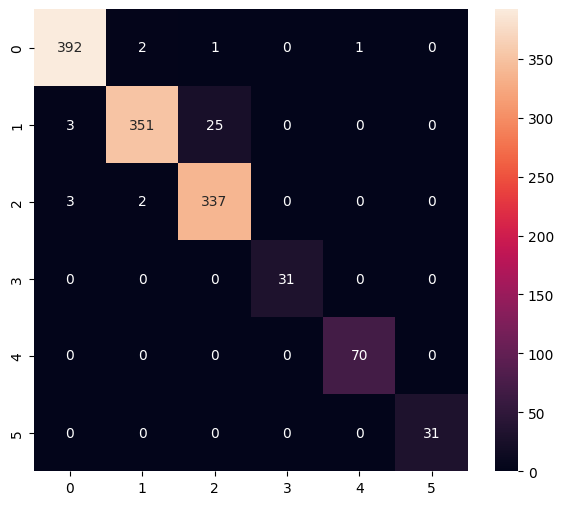

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       396
           1       0.99      0.93      0.96       379
           2       0.93      0.99      0.96       342
           3       1.00      1.00      1.00        31
           4       0.99      1.00      0.99        70
           5       1.00      1.00      1.00        31

    accuracy                           0.97      1249
   macro avg       0.98      0.98      0.98      1249
weighted avg       0.97      0.97      0.97      1249



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite 

In [17]:
# Save as a model for inference only
model.save(model_save_path)

In [18]:
# Convert model (quantize)
tflite_save_path = 'model/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\OKass\AppData\Local\Temp\tmpvbdmx66v\assets


INFO:tensorflow:Assets written to: C:\Users\OKass\AppData\Local\Temp\tmpvbdmx66v\assets


6632